## This notebook is intended to prepare extracted buoy data from the [CDIP website](https://cdip.ucsd.edu/) for a rogue wave forecasting task for buoys located in shallow/ intermediate water depths.

### The required libraries are imported here.

In [1]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from tensorflow import keras
import seaborn as sns
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix

- **A function to extract the wave heights and their respective indices in a given time series window. This is based on finding the zero-crossing incidents in the time window. Finally, the largest of the wave peaks in the window is found out.**
- **This is done to process the data in a manner such that the wave index is known where the maximum wave height is acheived and the data window can be slided accordingly to fit our neural network training process.**

**For feeding as input for the training of neural networks, the wave heights are standardized to values between -1 and 1**.
**A sample data window is displayed here.**
![random wave window](random_wave_window_manyOne.jpg)

In [2]:
def find_max_wave_height(zdisp_window):
    zero_crossings = np.where(np.diff(np.sign(zdisp_window)))[0]
    zero_crossings= np.append(zero_crossings, len(zdisp_window)-1);
    zero_crossings= np.append(-1,zero_crossings)
    h_wave=np.zeros(len(zero_crossings)-1)
    t_wave=np.zeros(len(zero_crossings)-1)
            
    for iter_zero_crossing in range(len(zero_crossings)-1):
        peak_idx=np.argmax(np.abs(zdisp_window[zero_crossings[iter_zero_crossing]+1:zero_crossings[iter_zero_crossing+1]+1]))
        h_wave[iter_zero_crossing]=zdisp_window[zero_crossings[iter_zero_crossing]+1+peak_idx]
        t_wave[iter_zero_crossing]=zero_crossings[iter_zero_crossing]+1+peak_idx
                
    max_wave_height=max(np.abs(np.diff(h_wave)))
    max_index = int(t_wave[np.argmax(np.abs(np.diff(h_wave)))])
    
    return max_wave_height, max_index

- **The objective of the rogue wave forecasting task is as follows.**
- **Given a window of time series data extracted from a buoy, the purpose of the task is to predict whether there will be a rogue wave within some fixed time horizon. The training data is prepared such that there are equal proportions of wave data windows leading to a rogue wave in the horizon and those that do not lead up to a rogue wave in the horizon.**
- **The training input is thus each such data window, while the output is determined by the presence or absence of a rogue wave at the end of the fixed forecasting horizon.**
- **Experiments have been carried out to observe the effect of both the length of the training data window as well as the forecast horiron used in this training process on the rogue wave forecasting accuracy of the trained neural network models.**  

**An overview of the data window used and the subsequent rogue wave to be forecast is displayed through the illustration here. The forecast horizon $t_{horizon}$ is varied between 3,5 and 10 minutes and the length of the trainign window $t_{window}$ is varied between 15 and 20 minutes to investigate their respective effects on the rogue wave forecasting accuracy.**
![forecasting_illustration](Slide3.jpg)

**Functions are created below to prepare the data windows leading upto rogue waves and those not leading upto rogue waves separately. These will be utilized to train our neural networks.**

In [3]:
def populate_rw_arrays(dir, array, start_idx, end_idx):
    for folder in os.listdir(dir):
        print("Processing: " + folder)
        
        start_time = time.time()
        for file in os.listdir(dir+ "/" + folder):
            if file.endswith(".npz"):
                data=np.load(dir+"/"+ folder+"/"+file)
                z_tmp=data['zdisp'][start_idx:end_idx]
                significant_wave_height=4*np.std(data['zdisp'])#[start_idx:-1]
                z_disp_rw.append(z_tmp/significant_wave_height)
                #print(z_disp_rw[0].shape)
        print("--- %s seconds ---" % (time.time() - start_time))
    return

In [4]:
def populate_norw_arrays(dir, array, end_idx):
    for folder in os.listdir(dir):
        print("Processing: " + folder)
        
        start_time = time.time()
        for file in os.listdir(dir+ "/" + folder):
            if file.endswith(".npz"):
                data=np.load(dir+"/"+ folder+"/"+file)
                z_tmp=data['zdisp_norw'][0:end_idx]
                significant_wave_height=4*np.std(data['zdisp_norw'])#[start_idx:-1]
                z_disp_norw.append(z_tmp/significant_wave_height)

        print("--- %s seconds ---" % (time.time() - start_time))
    return          

**The wave arrays are being created here (the training and the test datasets alternately)**

In [ ]:
root_folder_rw = os.getcwd()+"/buoy_network_g2_intermediate"
root_folder_norw = os.getcwd()+"/buoy_network_g2_intermediate"
# root_folder_rw = os.getcwd()+"/buoy_network_g2_intermediate_testing"
# root_folder_norw = os.getcwd()+"/buoy_network_g2_intermediate_testing"

#root_folder="E:/"

window_start_min_rel_to_rw=-18
window_length_in_min=15

samplerate=1.28

rw_idx=round(25*60*samplerate)
start_idx=round((25+window_start_min_rel_to_rw)*60*samplerate)
end_idx=start_idx+round(window_length_in_min*60*samplerate)

rw_dir=root_folder_rw + '/rw_samples'
z_disp_rw=[] 
#z_disp_rw_buoy_067=[] 
populate_rw_arrays(rw_dir, z_disp_rw, start_idx, end_idx)

z_disp_norw=[]
#z_disp_norw_buoy_067=[]
norw_dir=root_folder_norw + '/norw_samples'
#norw_dir=root_folder_norw 
end_idx=end_idx-start_idx
populate_norw_arrays(norw_dir, z_disp_norw, end_idx)

In [ ]:
z_disp_rw=np.vstack(z_disp_rw)
#z_disp_rw_buoy_067=np.vstack(z_disp_rw_buoy_067)
print(z_disp_rw.shape)

z_disp_norw=np.vstack(z_disp_norw)
#z_disp_norw_buoy_067=np.vstack(z_disp_norw_buoy_067)

print(z_disp_norw.shape)

In [ ]:
possible_total_waves = round(z_disp_rw.shape[0] + z_disp_norw.shape[0])
print(f"Total possible waves in our study: {possible_total_waves}")

### The training and the testing data arrays for the deep buoys here. 
- **Different datasets can be created by varying the $t_{horizon}$ and $t_{advance}$.**
- **For this case, the training data is obtained from 4 buoys located in intermediate water while the testing data is obtained from another buoy not used during the training process.**

The number of rogue wave samples in the case with relative rogue wave ratio 0.5 is 1553.
The number of non-rogue wave samples in the case with relative rogue wave ratio 0.5 is 1553.
The total number of wave samples in the case with relative rogue wave ratio 0.5 is 3106.
(1553, 1152)
(1553, 1152)


231
161
94


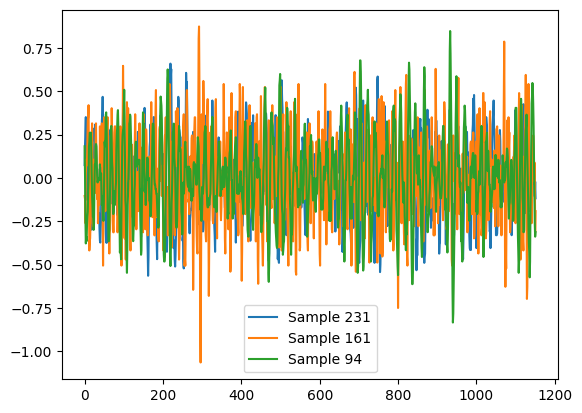

In [16]:
N_data=min([z_disp_rw.shape[0],z_disp_norw.shape[0]])
# relative_rw = [0.2, 0.3, 0.4, 0.5, 0.6 ,0.7, 0.8]
relative_rw = [0.5]

for i in range(len(relative_rw)):
    ratio = relative_rw[i]
    if ratio >= 0.5:
        num_rw = z_disp_rw.shape[0]
        num_norw = round(((1-ratio)/ratio) * num_rw)
    else:
        num_norw = z_disp_norw.shape[0]
        num_rw = round((ratio / (1-ratio))*num_norw)

    print(f"The number of rogue wave samples in the case with relative rogue wave ratio {ratio} is {num_rw}.")
    print(f"The number of non-rogue wave samples in the case with relative rogue wave ratio {ratio} is {num_norw}.")
    print(f"The total number of wave samples in the case with relative rogue wave ratio {ratio} is {num_rw + num_norw}.", end='\n') 
        
    z_disp_rw_altered = z_disp_rw[0:num_rw]
    z_disp_norw_altered = z_disp_norw[0:num_norw]
    
    print(z_disp_rw_altered.shape)
    print(z_disp_norw_altered.shape)
    print('\n')

    N_plots=3
    selected_samples=random.sample(range(0, len(z_disp_rw)), N_plots)

    plt.figure()
    for iter_plot in selected_samples:
        print(iter_plot)
        plt.plot(z_disp_rw[iter_plot,:], label='Sample '+str(iter_plot))

    plt.legend(loc='best')    
    plt.show()
    plt.close()

    wave_data=np.concatenate((z_disp_rw_altered, z_disp_norw_altered), axis=0)
    labels=np.concatenate(( np.ones(len(z_disp_rw_altered)) , np.zeros(len(z_disp_norw_altered))),axis=0)

    #wave_data_buoy_067=np.concatenate((z_disp_rw_buoy_067, z_disp_norw_buoy_067), axis=0)
    #labels_067=np.concatenate(( np.ones(len(z_disp_rw_buoy_067)) , np.zeros(len(z_disp_norw_buoy_067))),axis=0)

    idx = np.random.permutation(len(wave_data))
    wave_data = wave_data[idx]
    labels=labels[idx]

    #### CREATING THE TRAINING DATASETS
    
    # wave_data_train=wave_data[0:round(0.8*len(wave_data))]
    # wave_data_test=wave_data[round(0.8*len(wave_data))+1:]                                      

    # label_train=labels[0:round(0.8*len(wave_data))]
    # label_test=labels[round(0.8*len(wave_data))+1:]

    #### CREATING THE TESTING DATASETS

    wave_data_train=wave_data[0:round(0*len(wave_data))]
    wave_data_test=wave_data[round(0*len(wave_data))+1:]                                      

    label_train=labels[0:round(0*len(wave_data))]
    label_test=labels[round(0*len(wave_data))+1:]


    wave_data_train = wave_data_train.reshape((wave_data_train.shape[0], wave_data_train.shape[1], 1))
    wave_data_test = wave_data_test.reshape((wave_data_test.shape[0], wave_data_test.shape[1], 1))

    num_classes=2

    np.savez(os.getcwd()  +f'/DataPrepared/RWs_H_g_2_tadv_3min_intermediate_buoys_test_rw_{ratio}',wave_data_train=wave_data_train, wave_data_test=wave_data_test,label_train=label_train,label_test=label_test)

- **The different buoys used here for the experiments are displayed [here](all_water_buoys_with_distance.html). The deep water buoys are given by $d_{subscipt}$ and the shallow water buoys are given by $s_{subscipt}$. Testing is done using $s_{4}$. Training is done using data from all the other shallow water buoys.**